### The BeachNourisher Module

In this notebook we test and show the functionality of the BeachNourisher module within `CASCADE`.

In [1]:
import numpy as np
import sys
import time
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

sys.path.extend(['/Users/KatherineAnardeWheels/PycharmProjects/Barrier3D', '/Users/KatherineAnardeWheels/PycharmProjects/brie', '/Users/KatherineAnardeWheels/PycharmProjects/CASCADE'])
# datadir = "./B3D_Inputs/"  # laptop 
# Path(datadir)
datadir = "/Users/KatherineAnardeWheels/PycharmProjects/CASCADE/B3D_Inputs/"  # laptop

from CASCADE import Cascade
from scripts import CASCADE_plotters as CASCADE_Plt

Here we initialize `CASCADE` with the default wave climate and dune dynamics (average dune growth rate of 0.45), but increase the rate of sea level rise to 0.007 m/yr and simulate only one 500 m `Barrier3D` domain. All other optional modules are turned off (alongshore sediment transport from `BRIE`, community dynamics from `CHOME`, and roadway management). 

The nourishment module requires three input variables at initialization:
- `artificial_max_dune_ele`  # dune rebuilt to this height every nourishment, unless otherwise specified
- `nourishment_interval`  # yrs
- `nourishment_volume` 

CONTINUE EXPLAINING MODEL COMPONENTS SEQUENTIALLY HERE...turn dune migration off once we nourish (we don't allow the dune line to move seaward, as with natural progradation)

- will need to talk about how we are essentially averaging over the relaxation time for nourishment

In [2]:
# start a model by nourishing one B3D domain at discrete intervals, here we chose to start by nourishing every 15 years; 
# no roadway mgmt, otherwise default conditions except increase sea level rise to 0.005 m/yr
iB3D = 0
total_time = 100
cascade = Cascade(
    datadir,
    name="nourishment_intervals",
    sea_level_rise_rate=0.007,
    alongshore_section_count=1,
    time_step_count=total_time,
    num_cores=1,
    roadway_management_module=False,
    alongshore_transport_module=False,
    beach_nourishment_module=True,
#     community_dynamics_module=False,
    artificial_max_dune_ele=3.7,  # dune rebuilt to this height every nourishment
    nourishment_interval=15,  # yrs
    nourishment_volume=100,  # m^3/m -- 100 should produce about 20 m of shoreline progradation
)


# Loop for 50 years at a 15 year interval, 100 m^3/m and then 50 years at a 20 year interval with 300 m^3/m
nt = 50
for _ in tqdm(range(nt-1)):
    cascade.update()
    if cascade.road_break or cascade.b3d_break:
        break
        
# during the CASCADE initialization, the nourishment interval and volume is specified individually for each 
# barrier3d alongshore cell; so to update these values, we need to specify which barrier3d cell we want to modify
# (here, we only have one cell)
cascade.nourishment_interval[iB3D] = 20  # increase to 20 years
cascade.nourishment_volume[iB3D] = 300  # increase to 300 m^3/m

for _ in tqdm(range(nt)):
    cascade.update()
    if cascade.road_break or cascade.b3d_break:
        break

100%|██████████| 50/50 [00:10<00:00,  4.63it/s]


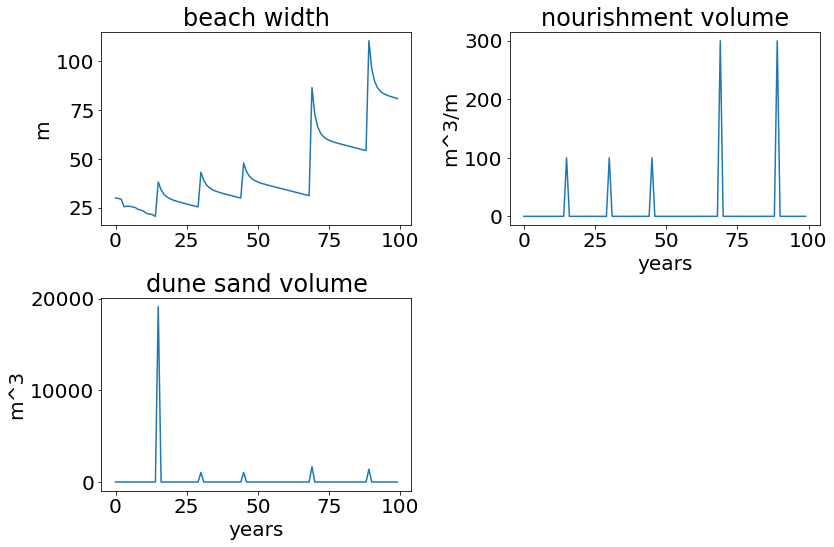

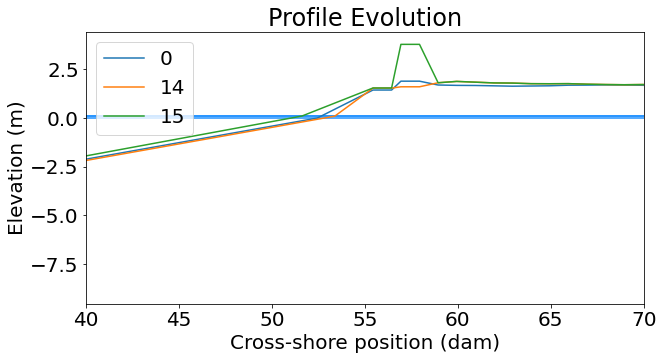

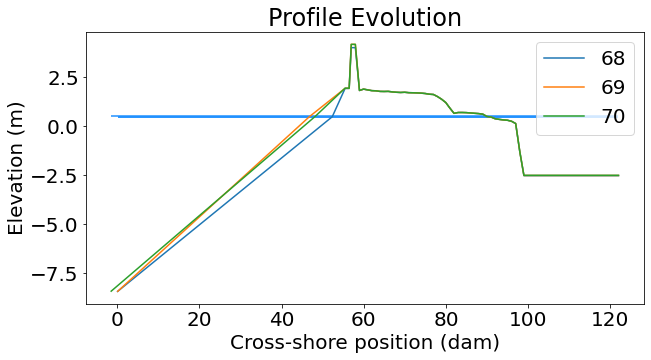

In [6]:
fig=plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.plot(cascade.nourishments[iB3D].beach_width)
plt.title("beach width")
plt.ylabel("m")

plt.subplot(2,2,2)
plt.plot(cascade.nourishments[iB3D]._nourishment_volume_TS)
plt.title("nourishment volume")
plt.ylabel("m^3/m")
plt.xlabel("years")

plt.subplot(2,2,3)
plt.plot(cascade.nourishments[iB3D]._rebuild_dune_volume_TS)
plt.title("dune sand volume")
plt.ylabel("m^3")
plt.xlabel("years")
fig.tight_layout()

time_step = [0,14,15]
fig = CASCADE_Plt.plot_ModelTransects(cascade, time_step, iB3D=0)
fig.set_xlim([40,70])
# fig.set_ylim([-1,3])

time_step = [68, 69, 70]
fig = CASCADE_Plt.plot_ModelTransects(cascade, time_step, iB3D=0)
# fig.set_xlim([50,60])
# fig.set_ylim([-1,3])

Remaining tests for Katherine: check different rates of sea level rise, add AST (want planform view for this), turn dune migration back on after <10 m beach width

In [ ]:
# start a model by nourishing one B3D domain at discrete intervals, here we chose to start by nourishing every 15 years; 
# no roadway mgmt, otherwise default conditions except increase sea level rise to 0.005 m/yr
iB3D = 0
total_time = 100
cascade = Cascade(
    datadir,
    name="nourishment_intervals",
    sea_level_rise_rate=0.007,
    alongshore_section_count=1,
    time_step_count=total_time,
    num_cores=1,
    roadway_management_module=False,
    alongshore_transport_module=False,
    beach_nourishment_module=True,
#     community_dynamics_module=False,
    artificial_max_dune_ele=3.7,  # dune rebuilt to this height every nourishment
    nourishment_interval=15,  # yrs
    nourishment_volume=100,  # m^3/m -- 100 should produce about 20 m of shoreline progradation
)

# loop for 100 years, but after each year, check the beach width and dune height and decide if you want to nourish
# or rebuild dune with nourish_now parameter
nt = 50
bw_threshold = 30  # must be greater than 10
dune_threshold = 1
for _ in tqdm(range(nt-1)):
    cascade.update()
    if cascade.road_break or cascade.b3d_break:
        break
        
    t = cascade.barrier3d[iB3D].time_index
    if cascade.nourishments[iB3D].beach_width[t-1] < bw_threshold:
        cascade.nourish_now = 1
    if cascade.barrier3d[iB3D]._HdAverageTS[t-1] < dune_threshold:   # I don't think this is the variable we should use
        cascade.rebuild_dune_now = 1
        
        


In [ ]:
     DuneDomainCrest = self._DuneDomain[self._time_index, :, :].max(
            axis=1
        )  # Maximum height of each row in DuneDomain
        DuneDomainCrest[DuneDomainCrest < self._DuneRestart] = self._DuneRestart

        self._Hd_AverageTS.append(
            np.mean(DuneDomainCrest)
        )  # Store average pre-storm dune-height for time step